In [1]:
using ComputationalHeatTransfer

In [2]:
# using Plots
using LaTeXStrings

In [3]:
using Revise
using LinearAlgebra
using DifferentialEquations
using Interpolations
# using JLD
using Plots
pyplot()  

┌ Warning: no Manifest.toml file found, static paths used
└ @ Revise C:\Users\liyux\.julia\packages\Revise\1boD5\src\packagedef.jl:1369


Plots.PyPlotBackend()

In [4]:
using JLD2

In [5]:
cd(dirname(pwd()))
cd("src") 

includet("OneDOHP.jl")
using ..OneDOHP

# the plate code initialization

### Physical parameters

In [6]:
# ρ = 2702;
# c = 9.03e02;
# k = 2.37e02;
# d = 2e-3;
# params = HeatConductionParameters(ρ,c,k,thickness=d)

In [7]:
ρ = 2700;
c = 8.97e02;
k = 1.67e02;
d = 2e-3;
params = HeatConductionParameters(ρ,c,k,thickness=d)

HeatConductionParameters(2700.0, 897.0, 167.0, 6.895412692514142e-5, 0.002)

### Geometry parameters

In [8]:
Lx = 0.1270;
Ly = 0.0648;
inch = 2.54e-2;

In [9]:
xlim = (-Lx/2,Lx/2) .*1.2
ylim = (-Ly/2,Ly/2) .*1.2
# Δx, Δt = setstepsizes(params.α,gridPe=0.1,fourier=200.0)
Δx, Δt = setstepsizes(params.α,gridPe=8.0,fourier=0.15)
# Δx, Δt = setstepsizes(params.α,gridPe=5.0,fourier=1000000.0)

Δt = 1e-3

0.001

### Set up the boundary of the domain

In [10]:
bdry = Rectangle(1.1.*Lx/2,1.1.*Ly/2,1.5Δx)

Rectangular body with 506 points and half-lengths (0.06985000000000001,0.03564)
   Current position: (0.0,0.0)
   Current angle (rad): 0.0


### Set up the evaporator and condenser

In [11]:
eb1 = Rectangle(0.5inch,1.5inch,1.5*Δx)
Te = RigidTransform((0.7inch,-0.0),0.0)
Te(eb1)

eb2 = Rectangle(0.5inch,1.5inch,1.5*Δx)
Te = RigidTransform((-0.7inch,-0.0),0.0)
Te(eb2)

cb1 = Rectangle(0.25inch,1.5inch,1.5*Δx)
Tc = RigidTransform((-2.5inch,-0.0),0.0)
Tc(cb1)

cb2 = Rectangle(0.25inch,1.5inch,1.5*Δx)
Tc = RigidTransform((2.5inch,-0.0),0.0)
Tc(cb2)

qe = 15500.0
hc = 2000.0
Tc = 0.0
# Tc = 0.0 - 10.0

eparams1 = PrescribedHeatFluxRegion(qe,eb1);
eparams2 = PrescribedHeatFluxRegion(qe,eb2);
cparams1 = PrescribedHeatModelRegion(hc,Tc,cb1);
cparams2 = PrescribedHeatModelRegion(hc,Tc,cb2);

### Set up the OHP

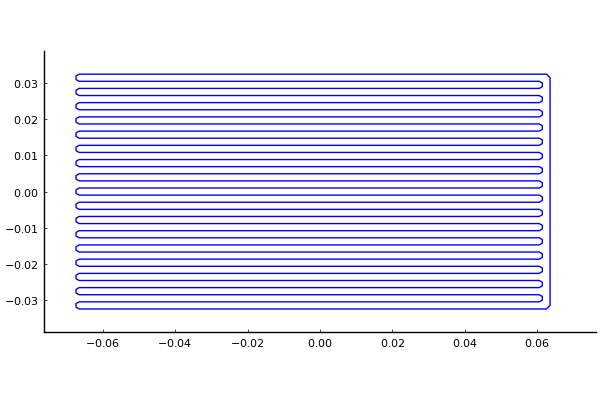

In [12]:
ds = 1.5Δx
nturn = 16
#pitch = 0.125
length_ohp = Ly
height = Lx
gap = d
pitch = length_ohp/(2*nturn+1)
x0, y0 = height/2, length_ohp/2
x, y, xf, yf = ComputationalHeatTransfer.construct_ohp_curve(nturn,pitch,height,gap,ds,x0,y0,false,false,3pi/2)
ohp = BasicBody(x,y)

plot(ohp,fillalpha=0,linecolor=:blue,xlims=xlim,ylims=ylim)


In [13]:
ohpgeom = ComputationalHeatTransfer.LineSourceParams(ohp)
qtmp = zeros(numpts(ohp));

### Create the system

In [14]:
sys = HeatConduction(params,Δx,xlim,ylim,Δt,bodies=BodyList([bdry]),qline=ohpgeom,qflux=[eparams1,eparams2],bctype=ComputationalHeatTransfer.AdiabaticBC,qmodel=[cparams1,cparams2])
#sys = HeatConduction(params,Δx,xlim,ylim,Δt,qline=ohpgeom)

Internal problem Heat conduction system on a grid of size 280 x 144 and 506 static immersed points
   1 body


#### Initialize state, and create the integrator

In [15]:
u0 = newstate(sys)
# tspan = (0.0,1.0)
tspan = (0.0,0.1)
integrator = init(u0,tspan,sys)

t: 0.0
u: (Primal nodes in a (nx = 280, ny = 144) cell grid of type Float64 data
  Number of Primal nodes: (nx = 279, ny = 143), Float64[])

### Set up values for the OHP heat flux per unit length and advance the solution

In [16]:
fill!(qtmp,-0.0)
set_linesource_strength!(sys,qtmp)

Internal problem Heat conduction system on a grid of size 280 x 144 and 506 static immersed points
   1 body


In [17]:
@time step!(integrator,1.0)
maximum(integrator.u[:])

147.669701 seconds (7.90 M allocations: 30.161 GiB, 2.35% gc time)


2.882243885630992

### Set the relative temperature back to [K]

In [18]:
T0 = 295.0 #[K]
# integrator.u += T0 - integrator.u[1,1]

295.0

### Plotting temperature contours

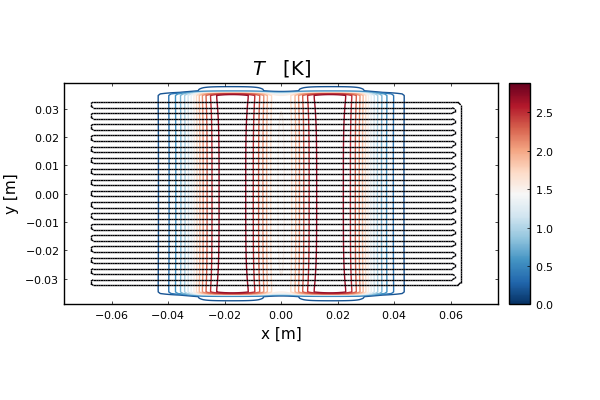

sys:1: UserWarning: The following kwargs were not used by contour: 'label'


In [19]:
plot(temperature(integrator),sys.grid,legend=true,color=cgrad(:RdBu,rev=true),line_z=0,xlabel="x [m]",ylabel="y [m]",title=L"T \quad [\mathrm{K}]")
plot!(ohp,fillalpha=0,line_z=0 .* qtmp)

In [185]:
integrator

t: 0.001
u: (Primal nodes in a (nx = 280, ny = 144) cell grid of type Float64 data
  Number of Primal nodes: (nx = 279, ny = 143), Float64[])

### Plot the temperature along the OHP channel

In [79]:
# plot(ohp,fillalpha=0,line_z=temperature_linesource(integrator))

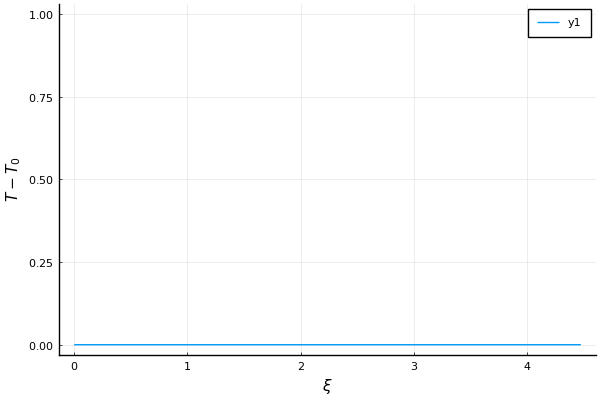

In [80]:
plot(sys.qline[1].arccoord,temperature_linesource(integrator),xlabel=L"\xi",ylabel=L"T - T_0")

# OHP inner part

In [81]:
nondi_Q_to_Q = 1.35E+02
t_to_nondi_t = 2.83E-01
function di_T_to_nondi_T(di_T;T0=295.0) 
    
    (di_T+T0)/T0
    
end



di_T_to_nondi_T (generic function with 1 method)

In [82]:
    ω = sqrt(2.45E+03);
    ℘L = 2.05E+05;
    k = 0.106024683

    θinitial=1.0
    θc = 1.0; # useless

    Hwc = 0.0; #not useful later on. H between wall and condenser, 
#     Hₗ   =  1600.0; # liquid wall heat transfer coeffcient
    Hₗ   =  2.32E+02; # liquid wall heat transfer coeffcient for static fluids
    Hδ  = 4.64E+02;


In [83]:
    d = 6.56e-3 # dimensionless diameter
    L = 35.0  # total length of the pipe when streched to a 1D pipe
    L2D = 1.0 # the actual length of the bended pipe in the real world
    angle = 0*pi/2 # inclination angle 
    closedornot = true

true

In [84]:
    nucleatenum = 256
    Xstations = sort(rand(nucleatenum).*L);
#     boilingΔt = 0.05

In [85]:
tube = Tube(d,L,L2D,angle,closedornot);

In [86]:
# useless
Xe = map(tuple, [1.0], [3.0])
We = [0.0]
evap = Evaporator(Xe,We);

In [87]:
# useless
Xc = map(tuple, [0.0,3.0], [1.0,4.0])
cond = Condenser(θc,Xc,Hwc);

In [88]:
# numofX=16
# Xps = sort(rand(2*numofX).*L);
# # Xps = LinRange(0.0,L,2*numofX+1);Xps = Xps[1:end-1];
# Xp1s = Xps[1:2:end];
# Xp2s = Xps[2:2:end];

# dXdt0 = map(tuple,0*Xp1s,0*Xp2s)
# X0 = map(tuple,Xp1s,Xp2s);


In [89]:
numofX=49
chargeratio = 0.45
# Xps = sort(rand(2*numofX).*L);
Xp1s = LinRange(0.0,L,numofX+1);Xp1s = Xp1s[1:end-1];
Xp2s = mod.((deepcopy(Xp1s) .+ L/numofX * chargeratio),L)
# Xp1s = Xps[1:2:end];
# Xp2s = Xps[2:2:end];

X0 = map(tuple,Xp1s,Xp2s);
# X0[1] = (1e-2,X0[1][2]); 
X0[1] = (L-1e-2,X0[1][2]); 
dXdt0 = map(tuple,0*Xp1s,0*Xp2s);

In [90]:
N=numpts(ohp)
# X0 = [(L2D*1/16, L2D*15/16)]
# dXdt0 = [(0.0,0.0)]
ρ = 102.593344 # density ratio
Xarrays,θarrays = constructXarrays(X0,N,θinitial,L)
liquids=Liquid(Hₗ,ρ,ω,℘L,X0,dXdt0,Xarrays,θarrays);

In [91]:
# P = [1.0,1.0,1.0,1.0,1.0]; # closed end

γ = 1.4;
Hδ = 4.64E+02
P = 0*zeros(length(X0)) .+ 1.0;
δ = 0*zeros(length(X0)) .+ 2.78E-02;
vapors=Vapor(γ,Hδ,P,δ);

In [92]:
α = 0 # nondimensional thermal diffusivity = (αₐ d^2) / (νₗ height^2)
Xwallarray,θwallarray = constructXarrays(L,N,θinitial)
θwallarray = di_T_to_nondi_T(temperature_linesource(integrator));

wall = Wall(α,Δt,Xstations,Xwallarray,θwallarray);

In [93]:
sys0_nomapping = PHPSystem_nomapping(tube,evap,cond,liquids,vapors,wall);
θ_interp_walltoliquid, θ_interp_liquidtowall, H_interp_liquidtowall, P_interp_liquidtowall = sys_interpolation(sys0_nomapping)
mapping = Mapping(θ_interp_walltoliquid, θ_interp_liquidtowall, H_interp_liquidtowall, P_interp_liquidtowall);

In [94]:
sys0 = PHPSystem(tube,evap,cond,liquids,vapors,wall,mapping);

### construct state vector U

In [95]:
Lvaporplug = XptoLvaporplug(X0,sys0.tube.L,sys0.tube.closedornot)
M = nondi_PtoD(P) .* Lvaporplug
# M = P.^(1/γ).* Lvaporplug


u=[XMδtovec(X0,dXdt0,M,δ); liquidθtovec(sys0.liquid.θarrays)];

In [96]:
cb_boiling =  DiscreteCallback(boiling_condition,boiling_affect!)
# cb_boiling =  PeriodicCallback(boiling_affect!,0.01*t_to_nondi_t)
cb_merging =  DiscreteCallback(merging_condition,merging_affect!)

cbst = CallbackSet(cb_boiling,cb_merging);

# combine inner tube and plate together

In [97]:
tspan = (0.0, 50.0);
dt_record = tspan[2] /250;
tstep=5e-4;

In [98]:
u0 = newstate(sys)
integrator_plate = init(u0,tspan,sys)

t: 0.0
u: (Primal nodes in a (nx = 280, ny = 144) cell grid of type Float64 data
  Number of Primal nodes: (nx = 279, ny = 143), Float64[])

In [99]:
p = sys0
u=[XMδtovec(X0,dXdt0,M,δ); liquidθtovec(sys0.liquid.θarrays)];
prob = ODEProblem(ODE_innertube, u, tspan, p)
integrator_tube = init(prob, RK4(),save_everystep=false, callback=cbst)

t: 0.0
u: 2745-element Array{Float64,1}:
 34.99
  0.32142857142857145
  0.7142857142857142
  1.0357142857142856
  1.4285714285714284
  1.75
  2.142857142857143
  2.464285714285714
  2.8571428571428568
  3.1785714285714284
  3.5714285714285716
  3.8928571428571423
  4.285714285714286
  ⋮
  1.0
  1.0
  1.0
  1.0
  1.0
  1.0
  1.0
  1.0
  1.0
  1.0
  1.0
  1.0

In [100]:
plate_hist = []
tube_hist  = []
currentsys = getcurrentsys(integrator_tube.u,sys0);

In [101]:

@time for t in tspan[1]:tstep:tspan[2]
    


    currentsys.wall.θarray = di_T_to_nondi_T(temperature_linesource(integrator_plate))
    currentsys = getcurrentsys(integrator_tube.u,currentsys)
    
    
    nondi_qtmp = sys_to_heatflux(currentsys)
    qtmp = nondi_Q_to_Q*nondi_qtmp
    set_linesource_strength!(sys,qtmp)
    
    
    # reinitialize the integrator_plate to avoid some mysterious problems
    integrator_plate = init(deepcopy(integrator_plate.u),(integrator_plate.t,integrator_plate.t + tstep),sys)
    step!(integrator_plate,tstep, true)
    
    
    # reinitialize the integrator_tube to avoid some mysterious problems
    prob = ODEProblem(ODE_innertube, deepcopy(integrator_tube.u), (integrator_plate.t*t_to_nondi_t-tstep*t_to_nondi_t,integrator_plate.t*t_to_nondi_t), currentsys)
    integrator_tube = init(prob, SSPRK22(), callback=cbst, dt=1e-4);
    solve!(integrator_tube);
#     @time step!(integrator_tube, tstep*t_to_nondi_t)

    if (mod(integrator_plate.t,dt_record) < 1e-6) || (mod(-integrator_plate.t,dt_record) < 1e-6)
        push!(plate_hist,deepcopy(integrator_plate)); 
        push!(tube_hist,deepcopy(integrator_tube));
        println(integrator_plate.t)
    end
    
end

0.20000000000000015
0.4000000000000003
0.5999999999999893
0.7999999999999673
0.9999999999999453
1.1999999999999234
1.3999999999999013
1.5999999999998793
1.7999999999998573
1.9999999999998352
2.199999999999902
2.399999999999969
2.6000000000000356
2.8000000000001024
3.000000000000169
3.200000000000236
3.400000000000303
3.6000000000003696
3.8000000000004364
4.000000000000503
4.200000000000392
4.400000000000281
4.60000000000017
4.800000000000059
4.9999999999999485
5.199999999999838
5.399999999999727
5.599999999999616
5.799999999999505
5.999999999999394
6.199999999999283
6.399999999999173
6.599999999999062
6.799999999998951
6.99999999999884
7.199999999998729
7.399999999998618
7.5999999999985075
7.799999999998397
7.999999999998286
8.19999999999853
8.399999999998775
8.599999999999019
8.799999999999264
8.999999999999508
9.199999999999752
9.399999999999997
9.600000000000241
9.800000000000486
10.00000000000073
10.200000000000975
10.400000000001219
10.600000000001463
10.800000000001708
11.0000000

LoadError: [91mknot-vectors must be sorted in increasing order[39m

In [102]:
        push!(plate_hist,deepcopy(integrator_plate)); 
        push!(tube_hist,deepcopy(integrator_tube));
        println(integrator_plate.t)

19.30400000000036


In [103]:
sysfinal = []
for i = 1:length(tube_hist)
    plate_hist[i].u += T0 - plate_hist[i].u[1,1]
    push!(sysfinal, deepcopy(getcurrentsys(tube_hist[i].u,tube_hist[i].p)))
end

In [104]:
# plot(ohp,fillalpha=0,line_z=temperature_linesource(integrator_plate))

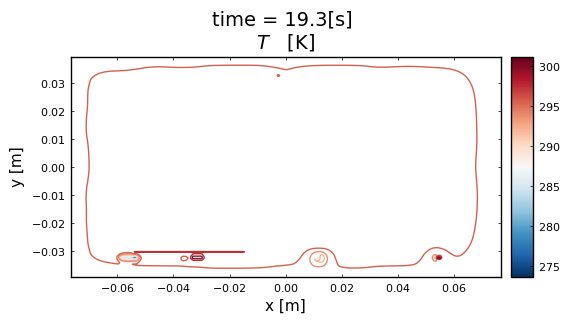

┌ Info: Saved animation to 
│   fn = C:\Users\liyux\Documents\GitHub\ComputationalHeatTransfer.jl\src\tmp.gif
└ @ Plots C:\Users\liyux\.julia\packages\Plots\FKcum\src\animation.jl:104


Plots.AnimatedGif("C:\\Users\\liyux\\Documents\\GitHub\\ComputationalHeatTransfer.jl\\src\\tmp.gif")
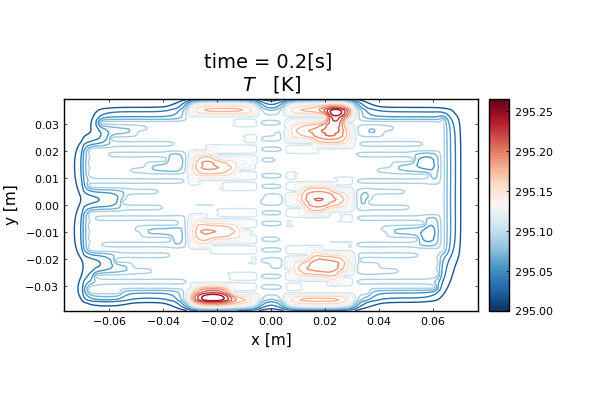

In [105]:
@gif for i = 1:1:length(plate_hist)
# @gif     for i = 1:1:1
Tmin = minimum(temperature(plate_hist[i])[:])
Tmax = maximum(temperature(plate_hist[i])[:])   
    
plot(temperature(plate_hist[i]),sys.grid,legend=true,color=cgrad(:RdBu,rev=true),clim=(Tmin,Tmax),line_z=0,xlabel="x [m]",ylabel="y [m]",title=string("time = ", round(plate_hist[i].t, digits=2), "[s] \n",  L"T \quad [\mathrm{K}]"))
# plot!(ohp,fillalpha=0,line_z=0 .* qtmp)
end

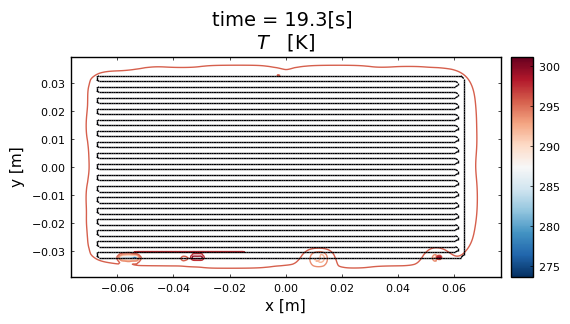

┌ Info: Saved animation to 
│   fn = C:\Users\liyux\Documents\GitHub\ComputationalHeatTransfer.jl\src\tmp.gif
└ @ Plots C:\Users\liyux\.julia\packages\Plots\FKcum\src\animation.jl:104


Plots.AnimatedGif("C:\\Users\\liyux\\Documents\\GitHub\\ComputationalHeatTransfer.jl\\src\\tmp.gif")
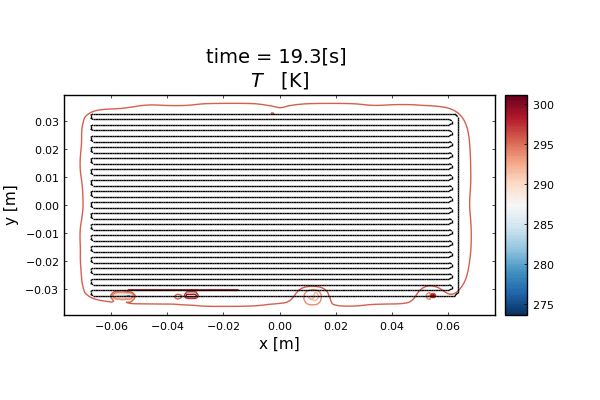

In [106]:
@gif for i = length(plate_hist):length(plate_hist):length(plate_hist)
# @gif     for i = 1:1:1
Tmin = minimum(temperature(plate_hist[i])[:])
Tmax = maximum(temperature(plate_hist[i])[:])   
    
plot(temperature(plate_hist[i]),sys.grid,legend=true,color=cgrad(:RdBu,rev=true),clim=(Tmin,Tmax),line_z=0,xlabel="x [m]",ylabel="y [m]",title=string("time = ", round(plate_hist[i].t, digits=2), "[s] \n",  L"T \quad [\mathrm{K}]"))
plot!(ohp,fillalpha=0,line_z=0 .* qtmp)
end

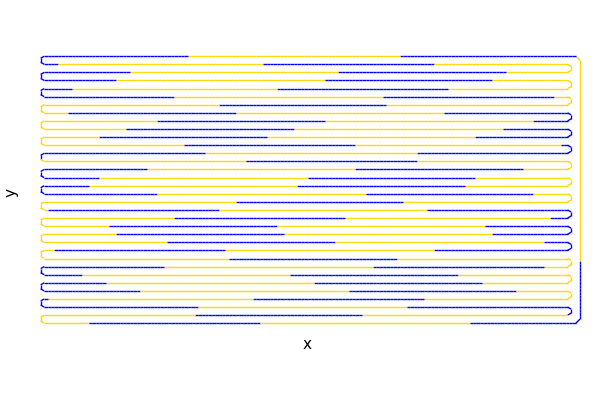

In [188]:
i = 1  
Htmp = sys_to_Harray(sysfinal[i])
    plot(ohp,fillalpha=0,linecolor=cgrad([:gold, :blue],rev=true),line_z=Htmp,xlabel="x ",ylabel="y ",border=:none,axis=nothing)

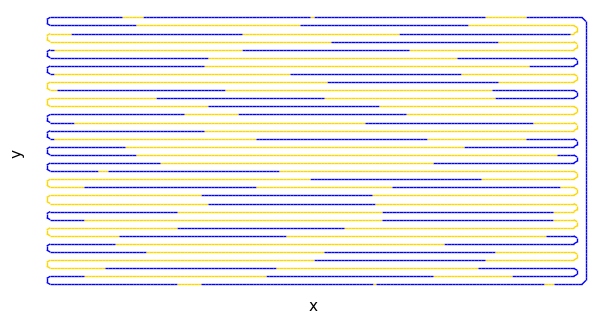

┌ Info: Saved animation to 
│   fn = C:\Users\liyux\Documents\GitHub\ComputationalHeatTransfer.jl\src\tmp.gif
└ @ Plots C:\Users\liyux\.julia\packages\Plots\FKcum\src\animation.jl:104


Plots.AnimatedGif("C:\\Users\\liyux\\Documents\\GitHub\\ComputationalHeatTransfer.jl\\src\\tmp.gif")
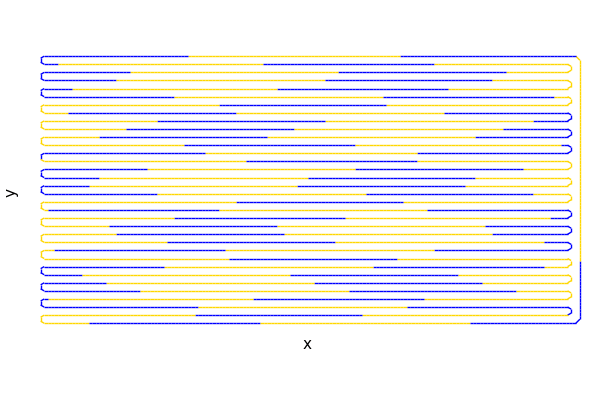

In [107]:
@gif for i=1:5:length(sysfinal)
    Htmp = sys_to_Harray(sysfinal[i])
    plot(ohp,fillalpha=0,linecolor=cgrad([:gold, :blue],rev=true),line_z=Htmp,xlabel="x ",ylabel="y ",border=:none,axis=nothing)
end

# plot the OHP

In [154]:
sysfinal[80].liquid.Xp

49-element Array{Tuple{Float64,Float64},1}:
 (34.75076994689797, 0.08219851832466143)
 (0.29448278974354836, 0.6159113611721299)
 (0.6233647502697671, 0.9447933216983574)
 (1.1063337226822645, 1.4277622941108628)
 (1.8162431639209053, 2.137671735349449)
 (2.4370056834498977, 2.758434254878469)
 (3.084248813327412, 3.4056773847559416)
 (3.950257584077803, 4.271686155506371)
 (4.717931123925867, 5.03935969535444)
 (5.443959845541485, 5.765388416970056)
 (6.2180295788040745, 6.539458150232646)
 (7.074598806274415, 7.396027377702905)
 (7.7944065452178535, 8.115835116646533)
 ⋮
 (27.257791505914685, 27.579220077343255)
 (27.991982019915152, 28.31341059134372)
 (28.87593408438217, 29.19736265581074)
 (29.570466310471485, 29.891894881900047)
 (30.248378788693547, 30.569807360122116)
 (31.16794565792288, 31.489374229351448)
 (31.845954085936125, 32.16738265736456)
 (32.42286369189268, 32.74429226332091)
 (33.15511198639795, 33.47654055782652)
 (33.63899094419901, 33.96041951562758)
 (33.995367

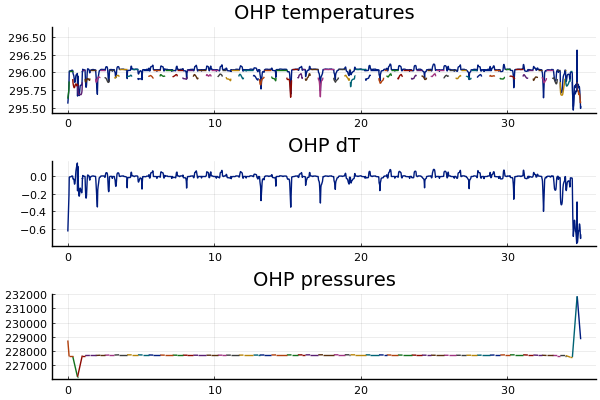

In [139]:
plot(sysfinal[76])

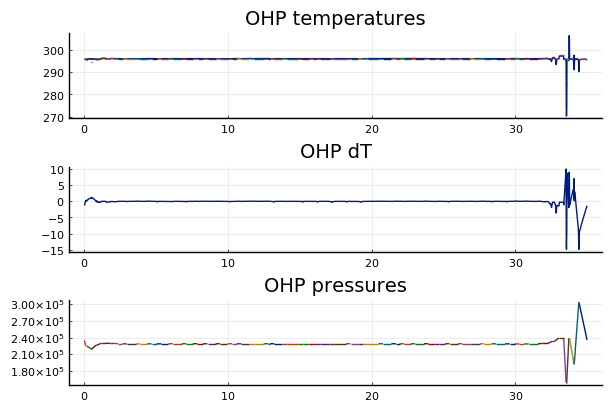

┌ Info: Saved animation to 
│   fn = C:\Users\liyux\Documents\GitHub\ComputationalHeatTransfer.jl\src\tmp.gif
└ @ Plots C:\Users\liyux\.julia\packages\Plots\FKcum\src\animation.jl:104


Plots.AnimatedGif("C:\\Users\\liyux\\Documents\\GitHub\\ComputationalHeatTransfer.jl\\src\\tmp.gif")
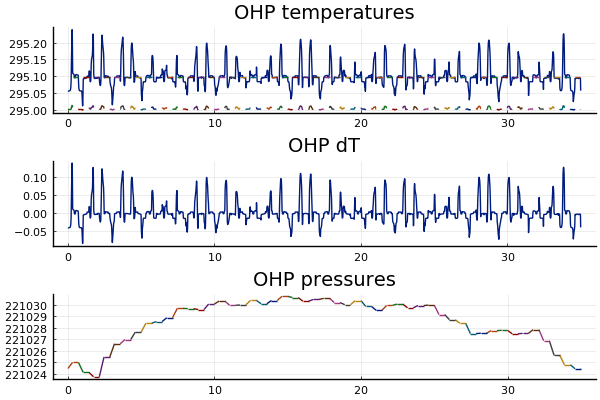

In [108]:
@gif for ii=1:length(sysfinal)
    plot(sysfinal[ii])
end

In [109]:
# save("plate_OHP.jld2", "plate_hist", plate_hist, "integrator_plate", integrator_plate)

In [110]:
# save("tube_OHP.jld2", "tube_hist", tube_hist, "integrator_tube",integrator_tube)

In [111]:
# @gif for i=1:5:length(sysfinal)
#     Htmp = sys_to_Harray(sysfinal[i])
#     plot(ohp,fillalpha=0,linecolor=cgrad([:gold, :blue],rev=true),line_z=Htmp,xlabel="x ",ylabel="y ",border=:none,axis=nothing)
# end

# temperature difference with OHP

### use the same definition of heat conductance in the ASET paper (temperature based on certain locations)

In [112]:
temp_evaporator = temperature(plate_hist[end])[110,48]

temp_condenser_1 = temperature(plate_hist[end])[44,48]
temp_condenser_2 = temperature(plate_hist[end])[end-44+1,48]
temp_condenser  = (temp_condenser_1+temp_condenser_2)/2

tempdiff_ASET = (temp_evaporator - temp_condenser) # K

0.05060147527217396

### use the same definition of heat conductance based on maximum and minimum temperatures)

In [113]:
tempdiff_maximum = maximum(temperature(plate_hist[end]))-minimum(temperature(plate_hist[end])) # K

27.4572907616394

# thermal conductance with OHP

### use the same definition of heat conductance in the ASET paper (temperature based on certain locations)

In [114]:
heater_power = 40 #watt
cond_ASET =  heater_power /tempdiff_ASET # W/K

790.4907867774407

### use the same definition of heat conductance based on maximum and minimum temperatures)

In [115]:
heater_power = 40 #watt
cond_maximum =  heater_power /tempdiff_maximum # W/K

1.4568079694113167

In [116]:
3+
3

6